https://inspiringpeople.github.io/data%20analysis/midi-music-data-extraction-using-music21/

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
'''# Defining some constants and creating a new folder for MIDIs.
midi_path = "MIDIs"
sonic_folder = "sonic"

!rm -r $midi_path
!mkdir $midi_path

# Some helper methods.    
def concat_path(path, child):
    return path + "/" + child

def download_midi(midi_url, path):
    !wget $midi_url --directory-prefix $path > download_midi.log

# Downloading an example file.
sonic_path = concat_path(midi_path, sonic_folder)
download_midi(
    "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",
    sonic_path)
    
print(os.listdir(sonic_path))'''

'# Defining some constants and creating a new folder for MIDIs.\nmidi_path = "MIDIs"\nsonic_folder = "sonic"\n\n!rm -r $midi_path\n!mkdir $midi_path\n\n# Some helper methods.    \ndef concat_path(path, child):\n    return path + "/" + child\n\ndef download_midi(midi_url, path):\n    !wget $midi_url --directory-prefix $path > download_midi.log\n\n# Downloading an example file.\nsonic_path = concat_path(midi_path, sonic_folder)\ndownload_midi(\n    "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",\n    sonic_path)\n    \nprint(os.listdir(sonic_path))'

In [7]:
# !pip install music21

In [8]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

sonic_path = 'MIDIs/sonic'


def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(os.path.join(sonic_path, "green-hill-zone.mid"), True)
base_midi


<music21.stream.Score 0x22572903580>

In [9]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Taken from:
www.alphalink.com.au/~kosy
WinJammer Demo
WinJammer Demo
WinJammer Demo
WinJammer Demo
WinJammer Demo
WinJammer Demo


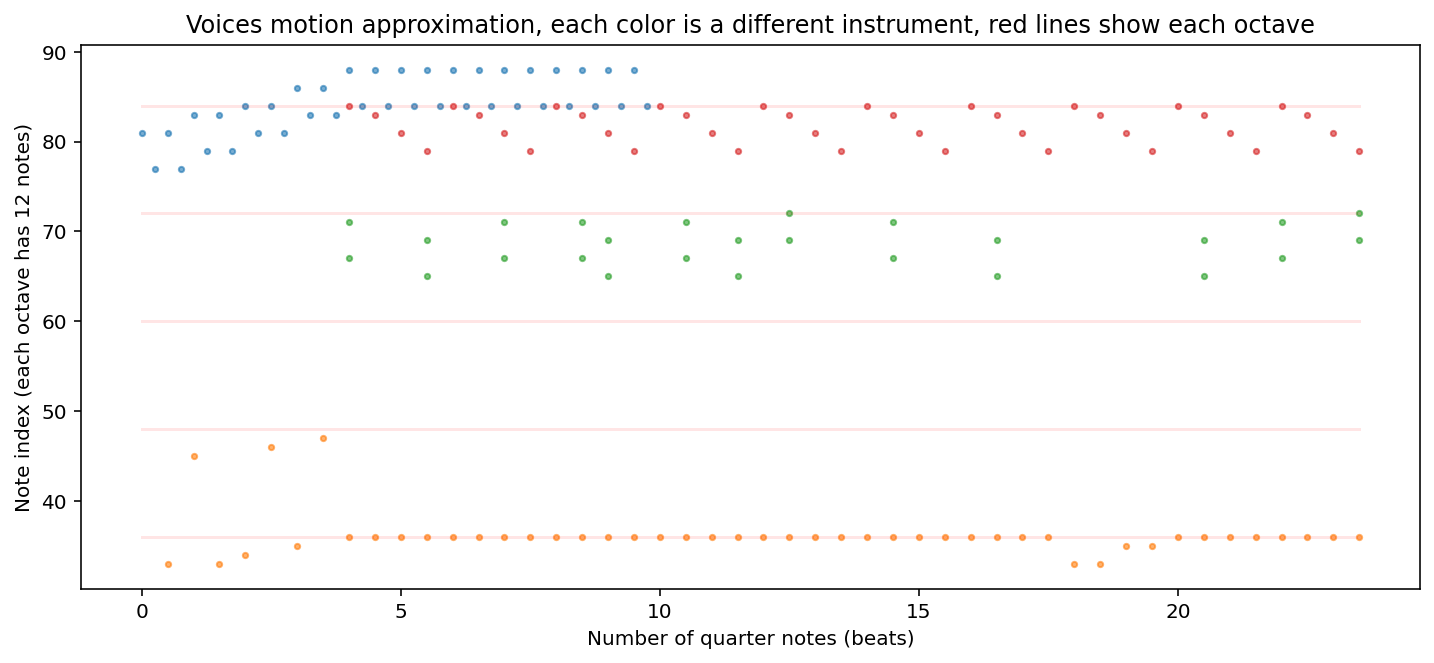

In [10]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x22572903580>>

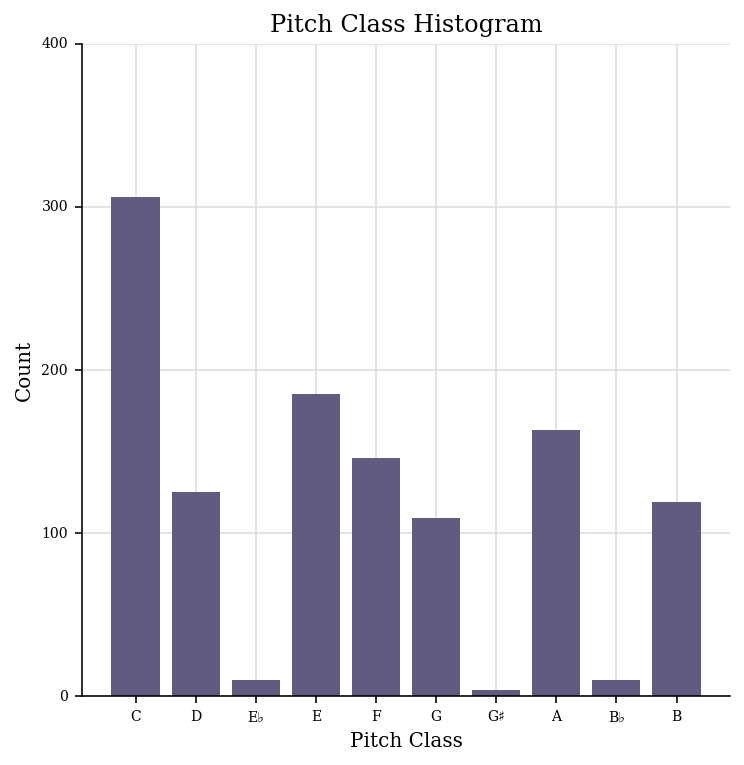

In [11]:
base_midi.plot('histogram', 'pitchClass', 'count')